In [12]:
import numpy as np
import pandas as pd
from os import listdir
from os.path import join, isfile

# info tables
sim_info = f'/data01/homes/dipiano/E4/irf_random/crab/sim/merged_simulator_data.dat'
map_info = f'/data01/homes/dipiano/E4/irf_random/crab/map_10s_5sgm/merged_mapper_data.dat'

# dataset 
filename = '/data01/homes/dipiano/E4/irf_random/crab/clean_50s_5sgm_5000sz_ctools_smooth.npy'
ds = np.load(filename, allow_pickle=True, encoding='latin1', fix_imports=True).flat[0]
print(f"Classes: {ds.keys()}\n")
print(f"NOISY dataset size: {len(ds['DS1'])}")
print(f"CLEAN dataset size: {len(ds['DS2'])}")

Classes: dict_keys(['DS1', 'DS2'])

NOISY dataset size: 5000
CLEAN dataset size: 5000


In [18]:
from astroai.tools.utils import split_noisy_dataset

train_noisy, train_clean, test_noisy, test_clean = split_noisy_dataset(ds, split=80, reshape=True, binning=250)

print(f"Train clean: {train_clean.shape}")
print(f"Train noisy: {train_noisy.shape}")
print(f"\nTest clean: {test_clean.shape}")
print(f"Test labenoicyls: {test_noisy.shape}")

Train clean: (4000, 250, 250, 1)
Train noisy: (4000, 250, 250, 1)

Test clean: (1000, 250, 250, 1)
Test labenoicyls: (1000, 250, 250, 1)


# !!! CHECK SIMULATE SAME POINTING !!!

In [19]:
sim_data = pd.read_csv(sim_info, sep=' ', header=0)
sim_data.head()

,name,seed,start,stop,duration,source_ra,source_dec,point_ra,point_dec,offset,irf,fov,sim_time
0,crab_06001,6001,0,300,300,239.074029,6.833570,239.181399,6.452206,0.395996,North_z60_5h_LST,2.5,7.227495
1,crab_06002,6002,0,300,300,237.754206,45.402908,237.440531,44.009991,1.410640,North_z20_N_0.5h_LST,2.5,8.644734
2,crab_06003,6003,0,300,300,354.400437,61.748337,356.354671,61.891396,0.933863,North_z20_S_50h_LST,2.5,7.380684
3,crab_06004,6004,0,300,300,130.780087,70.444515,130.764353,70.442876,0.005516,North_z20_5h_LST,2.5,7.727850
4,crab_06005,6005,0,300,300,327.214598,83.622918,316.785821,85.032426,1.740689,North_z40_N_50h_LST,2.5,7.383566


In [20]:
map_data = pd.read_csv(map_info, sep=' ', header=0)
map_data.head()

,name,seed,exposure,center_on,pixelsize,smooth,map_time
0,crab_07001,7001,10,pointing,0.02,5,1.279825
1,crab_07002,7002,10,pointing,0.02,5,0.940594
2,crab_07003,7003,10,pointing,0.02,5,1.192394
3,crab_07004,7004,10,pointing,0.02,5,0.988797
4,crab_07005,7005,10,pointing,0.02,5,1.282355


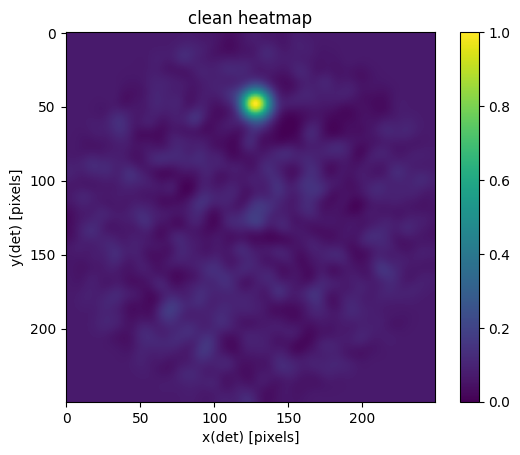

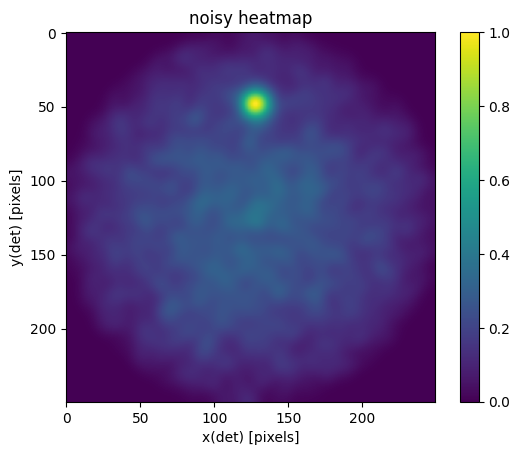

In [21]:
from astroai.tools.utils import plot_heatmap

idx = 10
plot_heatmap(train_clean[idx], title=f'clean heatmap', show=True, save=False, save_name=None)
plot_heatmap(train_noisy[idx], title=f'noisy heatmap', show=True, save=False, save_name=None)

In [ ]:
import tensorflow as tf
from datetime import datetime
from astroai.models.cnn import create_bkg_cleaner

autoencoder = create_bkg_cleaner(250)
autoencoder.summary()

In [ ]:
from astroai.models.cnn import compile_and_fit_cnn_bkg_cleaner

history = compile_and_fit_cnn_bkg_cleaner(model=model, train_noisy=train_noisy, train_clean=train_clean, 
                                          test_noisy=test_noisy, test_clean=test_clean, 
                                          batch_sz=32, epochs=25, shuffle=True, learning=0.001)

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2)
ax[0].plot(history.history['accuracy'], label='accuracy')
ax[0].plot(history.history['val_accuracy'], label = 'val_accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].set_ylim([0,1])
ax[0].legend(loc='lower right')

ax[1].plot(history.history['loss'], label='loss')
ax[1].plot(history.history['val_loss'], label = 'val_loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].set_ylim([0,1])
ax[1].legend(loc='lower right')

plt.tight_layout()
plt.show()

test_loss, test_acc = model.evaluate(test_data, test_labels, verbose=2)

In [ ]:
encoded_imgs = encoder.predict(x_test_noisy)
decoded_imgs = decoder.predict(encoded_imgs)

n = 10  # how many plots we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()